# Preprocessing and Windowing of our Dataset

In [15]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Add parent folder to sys.path
sys.path.append(os.path.abspath(".."))
from functools import reduce

from helpers.load_data import load_data
from helpers.load_data import load_and_merge_sensors
from helpers.load_data import collect_template_times
from helpers.filtering import preprocess_sensor_data
from helpers.segment import create_windows
import kagglehub

In [33]:
# Download latest version
path = kagglehub.dataset_download("rabieelkharoua/physical-therapy-exercises-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/hammy/.cache/kagglehub/datasets/rabieelkharoua/physical-therapy-exercises-dataset/versions/1


In [34]:
df, times = load_data(path)
tests = df[df['file_name'] == 'test.txt']
templates = df[df['file_name'] == 'template_session.txt']

In [35]:
filtered = []
normal = []
times_df = []
test = []

for subject in templates['subject'].unique():
    for exercise in templates['exercise'].unique():
        df = load_and_merge_sensors(templates, subject, exercise)
        normal.append(df)
        filtered.append(preprocess_sensor_data(df, smooth=False))

for subject in tests['subject'].unique():
    for exercise in tests['exercise'].unique():
        df = load_and_merge_sensors(tests, subject, exercise)
        test.append(preprocess_sensor_data(df, smooth=False))
        
for subject in times['subject'].unique():
    for exercise in times['exercise'].unique():
        df = collect_template_times(times, subject, exercise)
        times_df.append(df)

filtered[0], times_df[0], test[0]

(            acc_x_u1  acc_y_u1  acc_z_u1  gyr_x_u1  gyr_y_u1  gyr_z_u1  \
 time index                                                               
 1          -0.000301 -0.001568  0.001243  0.000050 -0.000418 -0.000081   
 2           0.003782 -0.012973 -0.000410  0.015997 -0.006485 -0.016916   
 3           0.031281 -0.024813 -0.012871  0.018531 -0.004887 -0.012574   
 4           0.038315 -0.011346 -0.018031  0.012086 -0.005786 -0.010628   
 5           0.016355  0.025431 -0.023982  0.008687 -0.009128 -0.018874   
 ...              ...       ...       ...       ...       ...       ...   
 2183       -0.013945 -0.018343  0.042704  0.002450 -0.007225  0.000241   
 2184       -0.008096 -0.006655  0.014861  0.001085 -0.001545 -0.000933   
 2185       -0.002071 -0.004450  0.002846 -0.002252 -0.001248 -0.006741   
 2186       -0.003578 -0.011499  0.010508  0.000281 -0.003599 -0.007077   
 2187       -0.003130 -0.001927  0.015718  0.000624 -0.000390  0.000636   
 
             mag_x_u1  

In [38]:
filtered_df = pd.concat(filtered)
normal_df = pd.concat(normal)
test_df = pd.concat(test)

label_map = {
    'e1': 1,
    'e2': 2,
    'e3': 3,
    'e4': 4,
    'e5': 5,
    'e6': 6,
    'e7': 7,
    'e8': 8
}

filtered_df['exercise'] = filtered_df['exercise'].map(label_map)
normal_df['exercise'] = normal_df['exercise'].map(label_map)
times['exercise'] = times['exercise'].map(label_map)

filtered_df.shape, normal_df.shape, test_df.shape

((55325, 47), (55325, 47), (220278, 47))

### Before vs. After

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def plot_labeled_sensor(df_labeled, sensors, title=None, figsize=(15,5), shade_alpha=0.2):
    """
    Plot multiple sensor signals on a single plot with shaded execution intervals.
    
    Args:
        df_labeled (pd.DataFrame): Sensor data with 'execution type' column and time as index.
        sensors (list of str): List of sensor column names to plot.
        title (str, optional): Plot title.
        figsize (tuple, optional): Figure size.
        shade_alpha (float, optional): Transparency of execution shading.
    """
    n_sensors = len(sensors)
    colors = matplotlib.colormaps.get_cmap('tab10').resampled(n_sensors)
  # distinct colors for sensors
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each sensor
    for i, sensor in enumerate(sensors):
        ax.plot(df_labeled.index, df_labeled[sensor], color=colors(i), label=sensor)
    
    # Shade execution intervals
    exec_types = df_labeled['execution type'].dropna().unique()
    cmap = matplotlib.colormaps.get_cmap('Set3').resampled(len(exec_types))
    
    for j, exec_type in enumerate(exec_types):
        mask = df_labeled['execution type'] == exec_type
        ax.fill_between(df_labeled.index, 
                        df_labeled[sensors].min().min()-0.1, 
                        df_labeled[sensors].max().max()+0.1, 
                        where=mask, 
                        color=cmap(j), 
                        alpha=shade_alpha,
                        label=f'Execution {exec_type}')
    
    ax.set_xlabel('Time index')
    ax.set_ylabel('Sensor values')
    if title:
        ax.set_title(title, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()


In [21]:
import pandas as pd

def label_subject_exercise(merged_df, times_df, subject_id, exercise_name):
    """
    Filter sensor data by subject and exercise, then label each row with execution type.
    Handles merge_asof dtype issues. Drops start/end columns after labeling.
    """
    # Filter by subject and exercise
    df = merged_df[(merged_df['subject'] == subject_id) & 
                   (merged_df['exercise'] == exercise_name)].copy()
    
    # Reset index for merge_asof
    df_reset = df.reset_index().rename(columns={'time index': 'time'})
    
    # Convert time to float to match times_df
    df_reset['time'] = df_reset['time'].astype(float)
    times_df = times_df.copy()
    times_df['start'] = times_df['start'].astype(float)
    times_df['end'] = times_df['end'].astype(float)
    
    # Sort by time
    df_reset = df_reset.sort_values('time')
    times_sorted = times_df.sort_values('start')
    
    # Merge_asof to assign execution type based on nearest start
    df_labeled = pd.merge_asof(
        df_reset,
        times_sorted,
        left_on='time',
        right_on='start',
        direction='backward'
    )
    
    # Set execution_type to NA if time > end
    df_labeled.loc[df_labeled['time'] > df_labeled['end'], 'execution type'] = pd.NA
    
    # Drop start and end columns
    df_labeled = df_labeled.drop(columns=['start', 'end'])
    
    # Restore index
    df_labeled = df_labeled.set_index('time')
    
    return df_labeled


In [22]:
sub = 's4'
ex = 2

sample_time = collect_template_times(times, sub, ex)
filtered_data = label_subject_exercise(filtered_df, sample_time, sub, ex)
normal_data = label_subject_exercise(normal_df, sample_time, sub, ex)

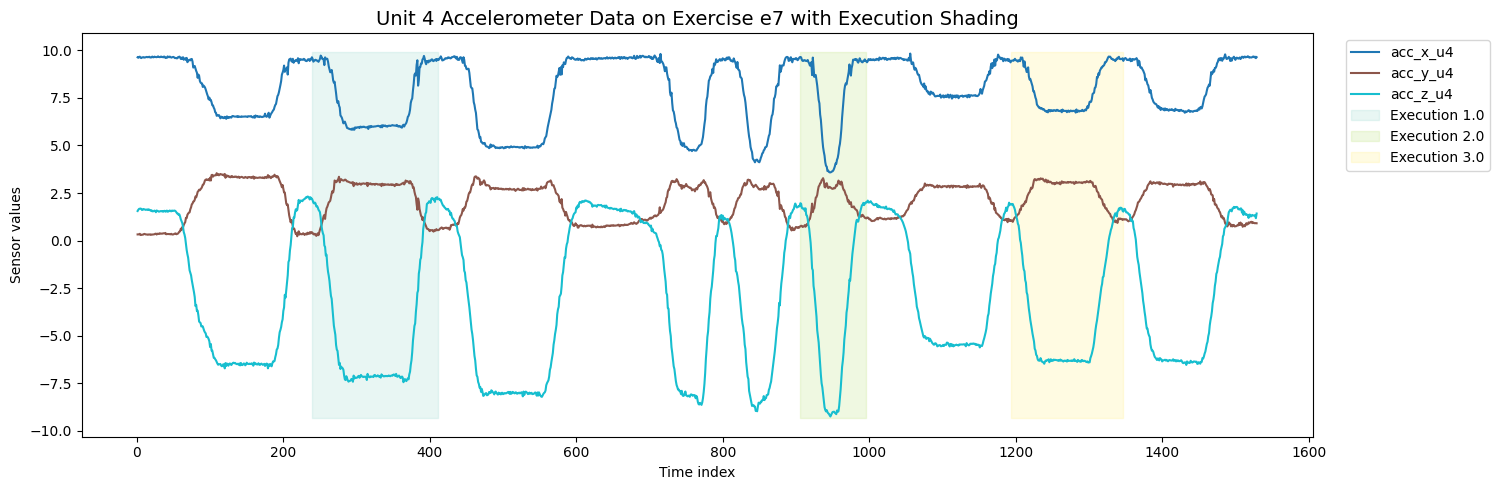

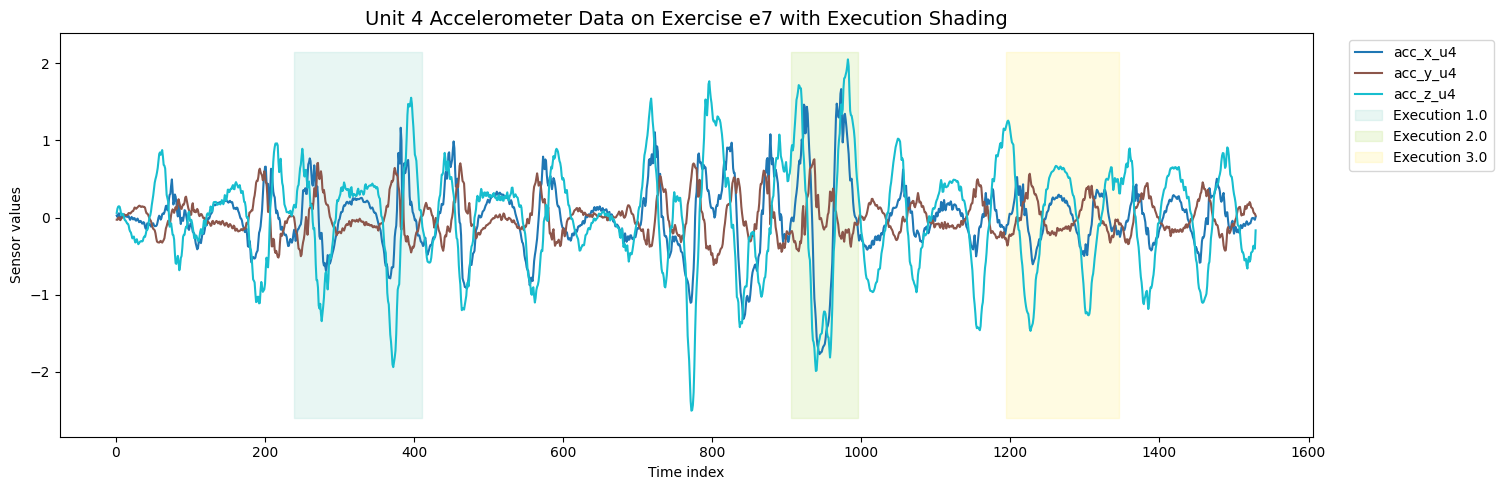

In [23]:
unit = 4

acc_sensors = [f'acc_x_u{unit}', f'acc_y_u{unit}', f'acc_z_u{unit}']
gyr_sensors = [f'gyr_x_u{unit}', f'gyr_y_u{unit}', f'gyr_z_u{unit}']
mag_sensors = [f'mag_x_u{unit}', f'mag_y_u{unit}', f'mag_z_u{unit}']

# Single sensor
plot_labeled_sensor(normal_data, acc_sensors, title=f'Unit {unit} Accelerometer Data on Exercise {exercise} with Execution Shading')

# Multiple sensors
plot_labeled_sensor(filtered_data, acc_sensors, 
                    title=f'Unit {unit} Accelerometer Data on Exercise {exercise} with Execution Shading')

## Windowing

In [24]:
sensor_cols = [col for col in filtered_df.columns if any(sensor in col for sensor in ['acc_', 'gyr_', 'mag_'])]


filter_segmented = create_windows(filtered_df, window_size=50, stride=25)

filter_segmented[0]

array([[[-3.01359478e-04, -1.56831525e-03,  1.24300146e-03, ...,
          1.53620000e-02,  7.34462000e-01,  2.04774000e-01],
        [ 3.78192918e-03, -1.29731440e-02, -4.09680418e-04, ...,
          1.44070000e-02,  7.35530000e-01,  2.05962000e-01],
        [ 3.12814869e-02, -2.48129084e-02, -1.28714497e-02, ...,
          1.45690000e-02,  7.36845000e-01,  2.04158000e-01],
        ...,
        [-5.22239263e-03, -1.62580759e-02,  1.42212097e-02, ...,
          1.56010000e-02,  7.35629000e-01,  2.04500000e-01],
        [ 7.80083833e-03, -3.81825753e-02,  2.65423394e-03, ...,
          1.64970000e-02,  7.35593000e-01,  2.04674000e-01],
        [ 1.22370157e-02, -3.55466247e-02, -3.73317525e-03, ...,
          1.39970000e-02,  7.36618000e-01,  2.02867000e-01]],

       [[ 9.21449930e-03,  2.20758458e-02, -1.84965707e-02, ...,
          1.51180000e-02,  7.35773000e-01,  2.04978000e-01],
        [-6.66416754e-03,  2.41145847e-03,  1.03847532e-02, ...,
          1.45800000e-02,  7.34863000e

In [43]:
import pickle

train_dict = {
    'data': filtered_df
}

test_dict = {
    'test_data': test_df
}

times_dict = {
    'times_df': times_df
}
with open('../data/training.pkl', 'wb') as f:
    pickle.dump(train_dict, f)
    
with open('../data/test.pkl', 'wb') as f:
    pickle.dump(test_dict, f)
    
with open('../data/time.pkl', 'wb') as f:
    pickle.dump(times_dict, f)